In [1]:
# 导入程序所需要的程序包

#抓取网页内容用的程序包
import json
#import requests

#PyTorch用的包
import torch
import torch.nn as nn
import torch.optim
from torch.autograd import Variable

# 自然语言处理相关的包
import re #正则表达式的包
import jieba #结巴分词包
from collections import Counter #搜集器，可以让统计词频更简单

#绘图、计算用的程序包
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [7]:
import gzip, json, re
from collections import defaultdict, Counter
from os import listdir
import sys
import pylab as plt
import matplotlib.cm as cm
import numpy as np
import random
from datetime import datetime
import statsmodels.api as sm
import time
from copy import deepcopy
from itertools import groupby
import itertools
import networkx as nx
from sklearn import manifold
import gensim
from scipy import spatial
from scipy.stats.stats import pearsonr
import matplotlib as mpl
from sklearn import cluster, covariance, manifold
from sklearn.manifold import TSNE,SpectralEmbedding,MDS,Isomap,LocallyLinearEmbedding
import pandas as pd
%matplotlib inline


def flushPrint(www):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % www)
    sys.stdout.flush()

In [31]:
df=pd.read_csv('/Users/lingfeiw/Documents/teaching/nanjingU/kaggle_fakenews/train.csv')
df=df.fillna(' ')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [45]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

In [171]:
W={}
stopset = set(stopwords.words('english'))
d=[]
l=[]
n=0
m=0
for title,author,text,label in zip(df['title'],df['author'],df['text'],df['label']):
    m+=1
    if m%100==0:
        flushPrint(m/100)#208
    s=title+' '+author+' '+text
    tokens=word_tokenize(s.decode('ascii','ignore').lower())
    tokens = [z for z in tokens if not z in stopset and len(z)>1]
    k=[]
    data=[(j,f) for j,f in Counter(tokens).items() if f>1]
    if data:
        total=float(sum(zip(*data)[1]))
        for j,f in data:
            if j not in W:
                W[j]=n
                n+=1
            k.append([W[j],f/total])
        d.append(k)
        l.append(label)

208

In [159]:
d[0]

[[0, 0.02608695652173913],
 [1, 0.008695652173913044],
 [2, 0.008695652173913044],
 [3, 0.017391304347826087],
 [4, 0.013043478260869565],
 [5, 0.013043478260869565],
 [6, 0.008695652173913044],
 [7, 0.06521739130434782],
 [8, 0.013043478260869565],
 [9, 0.008695652173913044],
 [10, 0.013043478260869565],
 [11, 0.008695652173913044],
 [12, 0.021739130434782608],
 [13, 0.008695652173913044],
 [14, 0.008695652173913044],
 [15, 0.008695652173913044],
 [16, 0.013043478260869565],
 [17, 0.034782608695652174],
 [18, 0.013043478260869565],
 [19, 0.030434782608695653],
 [20, 0.017391304347826087],
 [21, 0.013043478260869565],
 [22, 0.008695652173913044],
 [23, 0.008695652173913044],
 [24, 0.030434782608695653],
 [25, 0.013043478260869565],
 [26, 0.02608695652173913],
 [27, 0.017391304347826087],
 [28, 0.008695652173913044],
 [29, 0.021739130434782608],
 [30, 0.008695652173913044],
 [31, 0.017391304347826087],
 [32, 0.013043478260869565],
 [33, 0.008695652173913044],
 [34, 0.013043478260869565]

In [156]:
len(w)

66510

In [155]:
w.items()[:3]

[(u'fawn', 58952), (u'soestdijk', 59596), (u'glisson', 52563)]

In [157]:
len(d),len(l)

(20285, 20285)

In [158]:
Counter(l)

Counter({0: 10385, 1: 9900})

In [117]:
def sentence2vec(sentenceData, dictionary):
    vector = np.zeros(len(dictionary))
    for j,f in sentenceData:
        vector[j] =f
    return vector

In [118]:
dataset = [sentence2vec(j, w) for j in d] #数据集
labels = l #标签

In [119]:
indices = np.random.permutation(len(dataset))

#重新根据打乱的下标生成数据集dataset，标签集labels，以及对应的原始句子sentences
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]

#对整个数据集进行划分，分为：训练集、校准集和测试集，其中校准和测试集合的长度都是整个数据集的10分之一
test_size = len(dataset) // 10
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

valid_data = dataset[: test_size]
valid_label = labels[: test_size]

test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]

In [160]:
len(train_data),len(train_label)

(16229, 16229)

In [161]:
Counter(train_label)

Counter({0: 8269, 1: 7960})

In [143]:

# 输入维度为词典的大小：每一段评论的词袋模型
model = nn.Sequential(
    nn.Linear(len(w), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.LogSoftmax(),
)

def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

In [144]:
# 损失函数为交叉熵
cost = torch.nn.NLLLoss()
# 优化算法为Adam，可以自动调节学习率
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
records = []

#循环10个Epoch
losses = []
for epoch in range(2):
    ls=[]
    m=0
    for i, data in enumerate(zip(train_data, train_label)):
        m+=1
        if m%100==0:
            flushPrint(m/100)#162
        x, y = data
        
        # 需要将输入的数据进行适当的变形，主要是要多出一个batch_size的维度，也即第一个为1的维度
        x = Variable(torch.FloatTensor(x).view(1,-1))
        # x的尺寸：batch_size=1, len_dictionary
        # 标签也要加一层外衣以变成1*1的张量
        y = Variable(torch.LongTensor(np.array([y])))
        # y的尺寸：batch_size=1, 1
        
        # 清空梯度
        optimizer.zero_grad()
        # 模型预测
        predict = model(x)
        # 计算损失函数
        loss = cost(predict, y)
        # 将损失函数数值加入到列表中
        ls.append(loss.data.numpy()[0])
        # 开始进行梯度反传
        loss.backward()
        # 开始对参数进行一步优化
        optimizer.step()
    losses.append(np.mean(ls))
    print(epoch) 

1620
1621


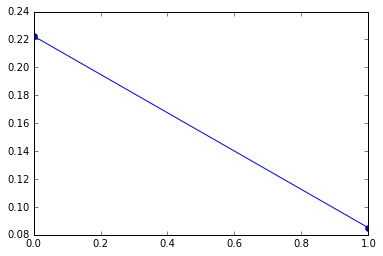

In [145]:
plt.plot(losses ,'bo-')

In [146]:
#在测试集上分批运行，并计算总的正确率
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for data, target in zip(test_data, test_label):
    data, target = Variable(torch.FloatTensor(data).view(1,-1)), Variable(torch.LongTensor(np.array([target])))
    output = model(data) #将特征数据喂入网络，得到分类的输出
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0] / rights[1]
right_rate

0.9388560157790927

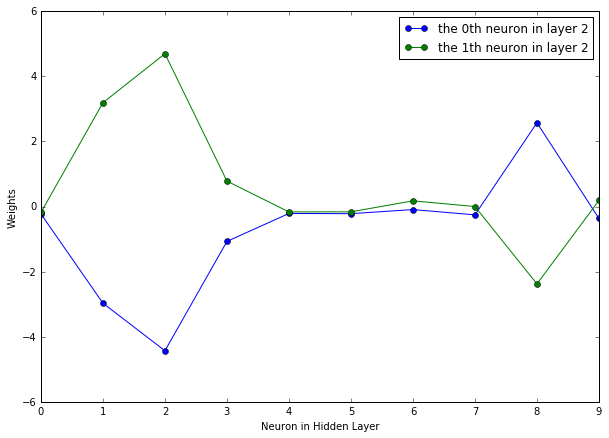

In [162]:
# 绘制出第二个全链接层的权重大小
# model[2]即提取第2层，网络一共4层，第0层为线性神经元，第1层为ReLU，第2层为第二层神经原链接，第3层为logsoftmax
plt.figure(figsize = (10, 7))
for i in range(model[2].weight.size()[0]):
    weights = model[2].weight[i].data.numpy()
    plt.plot(weights, 'o-', label ='the '+ str(i)+'th neuron in layer 2')
plt.legend()
plt.xlabel('Neuron in Hidden Layer')
plt.ylabel('Weights')

In [172]:
W1= dict((v,k) for k,v in W.items())

In [184]:
#for i in range(len(model[0].weight)):
i=2
k=50
print('\n')
print('第{}个神经元'.format(i))
print('max:')
st = sorted([(w,i) for i,w in enumerate(model[0].weight[i].data.numpy())])
for i in range(1, k):
    word = W1[st[-i][1]]
    print(word)
print('______________')
print('______________')
print('______________')
print('min:')
for i in range(k):
    word = W1[st[i][1]]
    print(word)



第2个神经元
max:
u.s.
's
''
``
october
president-elect
thus
n't
literally
hillarys
etc
survival
8th
al-qaeda
invasion
protectors
no-fly
simply
vis
saker
http
dapl
massive
justify
snip
vs.
so-called
right-wing
gary
doj
please
advertisement
unrest
us-led
9/11
anyone
una
outlook
propaganda
e-mail
cops
breaking
hatch
cop
consciousness
th
blame
steal
click
______________
______________
______________
min:
breitbart
000
u.
ms.
m.
s.
a.
2017
c.
hanchett
i.
ian
pam
b.
huston
jerome
mr.
d.
hudson
todd
o.
jeff
museum
inauguration
baker
nussbaum
islamic
key
trent
gwinn
coulter
quickly
pollak
march
miles
klein
critics
delingpole
features
f.
january
twitter
week
poor
ann
kew
countrys
com
warner
pic


In [182]:
x=np.zeros(len(W))
x[W['breitbart']]=1
x = Variable(torch.FloatTensor(x).view(1,-1))
predict = model(x)
predict

Variable containing:
  0.0000 -74.9621
[torch.FloatTensor of size 1x2]